# Deep Snakes
by Hermes, Channel and Jeanne. Rio de Janeiro, Brazil, 2018.

## Welcome to project Deep Snakes

In this series, we will try different machine learning approaches to identify two classes of snakes; python snakes (family pythonidae) and rattlesnakes (genera crotalus and sistrurus).

## Convolutional Neural Networks
In the previous notebook, we developed and tuned a shallow neural network, finishing with an error analysis, showing that most errors had no apparent causes. In this notebook, we use deep learning architectures to improve our model's capacity. In this notebook we will address:
* Using a two convolutional layer model (TensorFlow)
* Using the pioneering Deep Learning architecture AlexNet (Keras)
  * Performing online dataset augmentation (Keras)
  * Regularizing the model with dropout
  * Normalizing activations with batch norm

## Loading the dataset


In [0]:
import numpy as np
import h5py as h5
import tensorflow as tf
from supporting_functions_colab import snake_data
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
images_train_orig, labels_train_orig, images_dev_orig, labels_dev_orig = snake_data()
print("Shapes")
print("Images train:", images_train_orig.shape)
print("Labels train:", labels_train_orig.shape)
print("Images dev:", images_dev_orig.shape)
print("Labels dev:", labels_dev_orig.shape)

Shapes
Images train: (484, 128, 128, 3)
Labels train: (484,)
Images dev: (121, 128, 128, 3)
Labels dev: (121,)


This time we don't need to linearize the dataset, we will only normalize it and set the vector dimensions accordingly. Since CNNs deal with 2D images, the input is a 4D tensor with dimensions `[samples, width, height, channels]`, and the labels have dimensions `[samples,1]`, since this is a binary classification problem.

In [5]:
images_train = images_train_orig/255
labels_train = (labels_train_orig).reshape(-1,1)
images_dev = images_dev_orig/255
labels_dev = (labels_dev_orig).reshape(-1,1)
imsize = images_train.shape[1:3] # image_shape
dsize = images_train.shape[0] # amount of images
dsize_dev = images_dev.shape[0] # amount of dev images
print("Shapes")
print("Images train:", images_train.shape)
print("Labels train:", labels_train.shape)
print("Images dev:", images_dev.shape)
print("Labels dev:", labels_dev.shape)

Shapes
Images train: (484, 128, 128, 3)
Labels train: (484, 1)
Images dev: (121, 128, 128, 3)
Labels dev: (121, 1)


## Building the model
We begin with a simple approach: using two convolutional layers. The number of neurons in the dense layer is 420, chosen by hyperparameter tuning on the last notebook. Nextm we experiment with AlexNet which has more hidden layers, as well as other accessories to increase model expressiveness.

### Triple Layer CNN
Convolutional Neural Networks (CNN) are made by (as the name suggests), convolutional layers.  The first operation is convolving the image with filters in order to generate a 3D affine transformation matrix. To add the nonlinearity, intrinsic to neural networks, an activation function is applied over the affine transformation matrix to generate an activation matrix. Optinionally,  these layers ends with a pooling operation to reduce the matrix size along the first two axes. Pooling means aggregating the values of neighboting features or representations using a simple function like max or mean. 

Using a convolutional layers in sequence has the advantage of exponencially increasing the NN's expressive power, which brings two major advantages: less parameters and better accuracy, compared to a shalow (but wide) fully connected models.

Typically, as we go deeper into the model architecture, the height and width of the activation matrix decreases while the lenght increases. The last layer is usually a 1D flattened layer. So, we will start with two 2D convolutional layers, foloowed by a flattening operation.

In [0]:
def model_builder(cparams,hparams):
    # Builds the models placeholders for inputs and outputs, parameter 
    # variables and feed forward computation graph.
    # Argument: cparams - constant params, meaning, input/output dimensions.
    #           hparams - hyperparameters, meaning, hyperparameters. All of them.
    # Returns: tf objects regarding X, Y, logits and costs.
    #
    
    # getting win, hin, nout (inputs width and height, output # of classes)
    win = cparams["win"]
    hin = cparams["hin"]
    nout = cparams["nout"]
    
    # getting f1,c1,f2,c2. Stride on filters will be 1.
    f1 = hparams["f1"] # filter size of conv 1
    c1 = hparams["c1"] # num channels(filters) conv 1
    f2 = hparams["f2"] # there are 2 types of people in the world,
    c2 = hparams["c2"] # those who can extrapolate from incomplete information
    
    # getting p1, sp2 (pooling layer sizes, will consider size=stride)
    p1 = hparams["p1"]
    p2 = hparams["p2"]
    
    # planting the seed
    tf.set_random_seed(1988)
    
    # creating placeholders for input/output
    X = tf.placeholder(dtype=tf.float32,shape=[None,win,hin,3],name="X")
    Y = tf.placeholder(dtype=tf.float32,shape=[None,nout],name="Y")
    
    # first layer
    W1 = tf.get_variable('conv_1/W',shape=(f1,f1,3,c1), initializer=tf.glorot_normal_initializer(9))
    b1 = tf.get_variable('conv_1/b',shape=(c1),initializer=tf.zeros_initializer())
    conv_1 = tf.nn.bias_add(tf.nn.conv2d(X,W1,(1,1,1,1),'SAME'),b1)
    act_1 = tf.nn.relu(conv_1)
    pool_1 = tf.nn.max_pool(act_1, (1,p1,p1,1), (1,p1,p1,1), 'VALID')
    
    # second layer
    W2 = tf.get_variable('conv_2/W',shape=(f2,f2,c1,c2), initializer=tf.glorot_normal_initializer(8))
    b2 = tf.get_variable('conv_2/b',shape=(c2),initializer=tf.zeros_initializer())
    conv_2 = tf.nn.bias_add(tf.nn.conv2d(pool_1,W2,(1,1,1,1),'SAME'),b2)
    act_2 = tf.nn.relu(conv_2)
    pool_2 = tf.nn.max_pool(act_2, (1,p2,p2,1), (1,p2,p2,1), 'VALID')
    
    # flatten the 3D tensors
    flat = tf.layers.flatten(pool_2)
    
    # logits
    wpool = int(win/p1/p2)
    hpool = wpool
    cpool = c2
    W3 = tf.get_variable('dense_1/W',shape=(1,wpool*hpool*cpool), initializer=tf.glorot_normal_initializer(7))
    b3 = tf.get_variable('dense_1/b',shape=(1,1), initializer=tf.zeros_initializer())
    logits = tf.transpose(tf.matmul(W3,tf.transpose(flat))+b3)
    
    # cost
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=Y))
    reg = (tf.nn.l2_loss(W1) + 
           tf.nn.l2_loss(W2) + 
           tf.nn.l2_loss(W3))/tf.cast(tf.shape(X)[0],tf.float32)
    
    return X, Y,logits, cost, reg

Training the model. For minibatch split, we will try a different approach. Previously, when the number of samples was not divisible by the (mini)batch size, we split the data into n chunks, where n-1 were equally sized and the last one contained the remaining data, which could be of different size. Now, we will use numpy `array_split`:
>For an array of length `l` that should be split into `n` sections, it returns `l%n` sub-arrays of size l//n + 1 and the rest of size l//n.

Therefore, `batch_size` will no longer be constant, but bounded below by its value and upper bounded by `batch_size+1`. This may bring about some computational efficiency issue, but will minimize some effect cused by the last mini_batch being smaller than the rest.

In [0]:
def model_trainer(hparams, 
                  images_train = images_train, # Problematic if used incorrectly.
                  labels_train = labels_train, # watch out!
                  images_dev = images_dev, 
                  labels_dev = labels_dev, 
                  print_every=5):
    # Trains the model and saves the best iteration.
    # Argument: hparams - hyperparameters, meaning, hyperparameters. All of them.
    #           images_train - train set state tensor of inputs
    #           labels_train - train set state vector of outputs
    #           images_dev - dev set state tensor of inputs
    #           labels_dev - dev set state vector of outputs
    # Returns: train and dev set costs

    tf.set_random_seed(1111) # the answer to life the universe and everything
    np.random.seed(2222) # Is this a valid turing test question tho? 
    
    # number of train and dev samples
    n_train = images_train.shape[0]
    n_dev = images_dev.shape[0]
    
    # Retrieving hyperparameters
    epochs = hparams["epochs"]
    learning_rate = hparams["learning_rate"]
    batch_size = hparams["batch_size"]
    num_batches = n_train//batch_size
    lambd = hparams["lambd"]
    
    # determining cparams
    cparams = {"hin":images_train.shape[1], 
               "win":images_train.shape[2], 
               "nout":labels_train.shape[1]}
    
    # building the model
    X,Y,logits,cost, reg = model_builder(cparams,hparams)
    
    # bulding the floppy disc icon
    #saver = tf.train.Saver(max_to_keep = 1)
    
    # defining the optimizer
    cpr = cost+lambd*reg
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cpr)
    
    # defining the prediction
    pred = tf.sigmoid(logits)
    
    # I'm session and I know it!
    with tf.Session() as sess: 
        # Performance variables container
        costs_train = []
        costs_dev = []
        preds_train = []
        preds_dev = []
        accs_train = []
        accs_dev = []
        cost_dev_best = float("inf")
        
        # enumerating the samples
        indices = np.arange(n_train) 
        # note to self: don't use n or m, use explicit names. Almost screwed everything up.
        
        # Starting the global variables
        init = tf.global_variables_initializer()
        sess.run(init)
        
        # iterating through epochs
        for epoch in range(epochs+1): # epochs+1 to facilitate print_every
            # everyday I'm shufflin
            indices = np.random.permutation(indices)
            splits = np.array_split(indices,num_batches)
            cost_train = 0.
            
            # running mini batches
            pred_train = np.zeros([n_train,1])
            for split in splits:
                _,temp_cost = sess.run([optimizer,cost],feed_dict={X:images_train[split],Y:labels_train[split]})
                cost_train += temp_cost/num_batches
                pred_train[split] = sess.run(pred, feed_dict={X:images_train[split],Y:labels_train[split]})
            # storing train cost
            costs_train.append(cost_train)
            preds_train.append(pred_train)
            
            # computing dev cost
            cost_dev=0.
            pred_dev = np.zeros([n_dev,1])
            # will divide into samples to minimize mamory usage
            samples = np.array_split(np.arange(n_dev),n_dev/16)
            for sample in samples:
                cost_dev += sess.run(cost, feed_dict={X:images_dev[sample],Y:labels_dev[sample]})/(n_dev/16)
                pred_dev[sample] = sess.run(pred,feed_dict={X:images_dev[sample],Y:labels_dev[sample]})
            costs_dev.append(cost_dev)
            preds_dev.append(pred_dev)
            
            # using numpy to calculate the accuracies (less verbosity)
            acc_train = np.mean(np.equal(np.greater(pred_train,0.5).astype(int),labels_train))
            acc_dev = np.mean(np.equal(np.greater(pred_dev,0.5).astype(int),labels_dev))
            accs_train.append(acc_train)
            accs_dev.append(acc_dev)
            # saving the best parameters for later reuse
            if cost_dev < cost_dev_best:
                #saver.save(sess,"./bestfitcnn.dat")
                cost_dev_best = cost_dev
            
            # print output
            if not epoch%print_every:
                print("Epoch {}".format(epoch))
                print(" - loss: {:6.4f} - acc: {:6.4f} - val_loss: {:6.4f} - val_acc: {:6.4f}".format(cost_train,acc_train,cost_dev,acc_dev))
                
        return costs_train, costs_dev, accs_train, accs_dev, preds_train, preds_dev

Run Lola run!

In [8]:
%%time
tf.reset_default_graph()
# f1 = filter 1 size, c1 = number of channels (filters), p1 = size of pooling
hparams = {"f1":5, "c1":48, "p1":2,
           "f2":3, "c2":128, "p2":2,
           "epochs":500,
           "learning_rate":2e-6, 
           "batch_size":4, 
           "lambd":0.2}
costs_train, costs_dev, accs_train, accs_dev, preds_train, preds_dev = model_trainer(hparams, print_every=1)

Epoch 0
 - loss: 0.6949 - acc: 0.4669 - val_loss: 0.6445 - val_acc: 0.4711
Epoch 1
 - loss: 0.6929 - acc: 0.5186 - val_loss: 0.6434 - val_acc: 0.5041
Epoch 2
 - loss: 0.6910 - acc: 0.5496 - val_loss: 0.6409 - val_acc: 0.4876
Epoch 3
 - loss: 0.6893 - acc: 0.5579 - val_loss: 0.6389 - val_acc: 0.5702
Epoch 4
 - loss: 0.6868 - acc: 0.6136 - val_loss: 0.6388 - val_acc: 0.5207
Epoch 5
 - loss: 0.6852 - acc: 0.6198 - val_loss: 0.6377 - val_acc: 0.5372
Epoch 6
 - loss: 0.6834 - acc: 0.6095 - val_loss: 0.6352 - val_acc: 0.6033
Epoch 7
 - loss: 0.6818 - acc: 0.6302 - val_loss: 0.6348 - val_acc: 0.5372
Epoch 8
 - loss: 0.6802 - acc: 0.6364 - val_loss: 0.6328 - val_acc: 0.5868
Epoch 9
 - loss: 0.6787 - acc: 0.6446 - val_loss: 0.6335 - val_acc: 0.5620
Epoch 10
 - loss: 0.6761 - acc: 0.6322 - val_loss: 0.6301 - val_acc: 0.6033
Epoch 11
 - loss: 0.6748 - acc: 0.6508 - val_loss: 0.6289 - val_acc: 0.5950
Epoch 12
 - loss: 0.6730 - acc: 0.6756 - val_loss: 0.6277 - val_acc: 0.5868
Epoch 13
 - loss: 0.67

Epoch 150
 - loss: 0.5375 - acc: 0.7562 - val_loss: 0.5500 - val_acc: 0.6942
Epoch 151
 - loss: 0.5348 - acc: 0.7665 - val_loss: 0.5513 - val_acc: 0.6777
Epoch 152
 - loss: 0.5344 - acc: 0.7583 - val_loss: 0.5495 - val_acc: 0.6860
Epoch 153
 - loss: 0.5318 - acc: 0.7583 - val_loss: 0.5564 - val_acc: 0.6777
Epoch 154
 - loss: 0.5340 - acc: 0.7541 - val_loss: 0.5529 - val_acc: 0.6860
Epoch 155
 - loss: 0.5326 - acc: 0.7562 - val_loss: 0.5500 - val_acc: 0.6860
Epoch 156
 - loss: 0.5331 - acc: 0.7748 - val_loss: 0.5488 - val_acc: 0.6860
Epoch 157
 - loss: 0.5308 - acc: 0.7686 - val_loss: 0.5529 - val_acc: 0.6860
Epoch 158
 - loss: 0.5309 - acc: 0.7562 - val_loss: 0.5509 - val_acc: 0.6942
Epoch 159
 - loss: 0.5297 - acc: 0.7665 - val_loss: 0.5503 - val_acc: 0.6942
Epoch 160
 - loss: 0.5319 - acc: 0.7603 - val_loss: 0.5492 - val_acc: 0.6860
Epoch 161
 - loss: 0.5295 - acc: 0.7707 - val_loss: 0.5509 - val_acc: 0.6860
Epoch 162
 - loss: 0.5283 - acc: 0.7748 - val_loss: 0.5471 - val_acc: 0.6777

Epoch 300
 - loss: 0.4539 - acc: 0.8202 - val_loss: 0.5431 - val_acc: 0.6694
Epoch 301
 - loss: 0.4537 - acc: 0.8202 - val_loss: 0.5394 - val_acc: 0.7025
Epoch 302
 - loss: 0.4529 - acc: 0.8285 - val_loss: 0.5437 - val_acc: 0.6694
Epoch 303
 - loss: 0.4537 - acc: 0.8223 - val_loss: 0.5395 - val_acc: 0.7025
Epoch 304
 - loss: 0.4531 - acc: 0.8264 - val_loss: 0.5435 - val_acc: 0.6694
Epoch 305
 - loss: 0.4555 - acc: 0.8161 - val_loss: 0.5411 - val_acc: 0.6777
Epoch 306
 - loss: 0.4532 - acc: 0.8264 - val_loss: 0.5421 - val_acc: 0.6777
Epoch 307
 - loss: 0.4512 - acc: 0.8244 - val_loss: 0.5411 - val_acc: 0.6777
Epoch 308
 - loss: 0.4509 - acc: 0.8285 - val_loss: 0.5443 - val_acc: 0.6694
Epoch 309
 - loss: 0.4516 - acc: 0.8306 - val_loss: 0.5408 - val_acc: 0.6860
Epoch 310
 - loss: 0.4514 - acc: 0.8285 - val_loss: 0.5501 - val_acc: 0.6612
Epoch 311
 - loss: 0.4486 - acc: 0.8244 - val_loss: 0.5529 - val_acc: 0.6612
Epoch 312
 - loss: 0.4493 - acc: 0.8347 - val_loss: 0.5400 - val_acc: 0.7025

Epoch 450
 - loss: 0.3969 - acc: 0.8471 - val_loss: 0.5470 - val_acc: 0.6942
Epoch 451
 - loss: 0.3960 - acc: 0.8512 - val_loss: 0.5483 - val_acc: 0.6777
Epoch 452
 - loss: 0.3948 - acc: 0.8492 - val_loss: 0.5479 - val_acc: 0.6942
Epoch 453
 - loss: 0.3915 - acc: 0.8574 - val_loss: 0.5472 - val_acc: 0.6694
Epoch 454
 - loss: 0.3940 - acc: 0.8492 - val_loss: 0.5559 - val_acc: 0.6777
Epoch 455
 - loss: 0.3942 - acc: 0.8471 - val_loss: 0.5471 - val_acc: 0.7025
Epoch 456
 - loss: 0.3949 - acc: 0.8492 - val_loss: 0.5471 - val_acc: 0.6942
Epoch 457
 - loss: 0.3924 - acc: 0.8492 - val_loss: 0.5482 - val_acc: 0.6942
Epoch 458
 - loss: 0.3912 - acc: 0.8554 - val_loss: 0.5474 - val_acc: 0.6694
Epoch 459
 - loss: 0.3932 - acc: 0.8492 - val_loss: 0.5477 - val_acc: 0.6942
Epoch 460
 - loss: 0.3919 - acc: 0.8492 - val_loss: 0.5476 - val_acc: 0.6942
Epoch 461
 - loss: 0.3916 - acc: 0.8616 - val_loss: 0.5513 - val_acc: 0.6694
Epoch 462
 - loss: 0.3891 - acc: 0.8678 - val_loss: 0.5476 - val_acc: 0.6942

Analyzing the results:

In [9]:
best_epoch = np.argmin(costs_dev)
cost_train = costs_train[best_epoch]
cost_dev = costs_dev[best_epoch]
acc_train = accs_train[best_epoch]
acc_dev = accs_dev[best_epoch]
print("The best epoch is {}".format(best_epoch))
print(" - loss: {:6.4f} - acc: {:6.4f} - val_loss: {:6.4f} - val_acc: {:6.4f}".format(cost_train,acc_train,cost_dev,acc_dev))

The best epoch is 286
 - loss: 0.4604 - acc: 0.8347 - val_loss: 0.5392 - val_acc: 0.6942


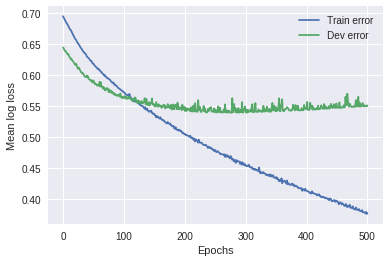

In [10]:
train_curve, = plt.plot(costs_train, label = 'Train error')
test_curve,  = plt.plot(costs_dev, label = 'Dev error')
plt.legend(handles=[train_curve,test_curve])
plt.xlabel('Epochs')
plt.ylabel('Mean log loss')
plt.show()

This result shows that, by using two hidden convolutional layers, the model rendered a close accuracy to the shallow NN a dev error about 9% lower.  Although these are only modest differences, especially for accuracy, this intermediate result reveals a crucial fact: there are over 100 times less parameters in this CNN (190,017) than in the shallow NN (20,644,681). This is a clear demonstration of the expressivity power that convolutional neural networks have over shallow fully connected NN, and shows why we should stick to this type of architecture for real improvements in the accuracy.

### AlexNet
[AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) is the pioneer deep learning architecture. Developed by Alex Krizhevsky, Ilya Sutskever and the godfather of Deep Learning, Geofrey Hinton, this algorithm won the ILSVR 2012 competition by a large marging, proving that deep learning was the top technique for image classification and localization.

Alexnet hidden layer architecture is made of eight layers, five convolutional and two fully connected with the following characteristic:
* 96 kernels (filters) of size 11x11x3 with a stride of 4 pixels;
    * Response normalization
    * Pooling (size 3, stride 2)
* 256 kernels of size 5x5x96
    * Response normalization
    * Pooling (size 3, stride 2)
* 384 kernels of size 3x3x256
* 384 kernels of size 3x3x384
* 256 kernels of size 3x3x384
* Two consecutive fully connected layers with 4096 neurons each
    * With dropout rate of 0.5

Our problem differs from the original problem in two aspects: 
1. The input images were 224x224x3 pixels, while our problem images are 128x128x3 pixels. 
2. The original problem was a classification with 1000 possible classes, ours have only two.

We will build a similar architecture with another two considerations. 
1. The original paper used local response normalization. We will use batch normalization.
2. The original architecture had two networks, interconnected on layers 3, 6 and 7. We will use only one.

Due to the second consideration, all number of filters and neurons in the dense layers will be half the size of the original architecture. This shouldn't be a problem since our number of classes is considerably smaller.

The original paper performs dataset augmentation. In this work, we will also use this technique applying random width and height shift, random zooming and random horizontal flip.

We shall now use Keras sequential model with tensorflow backend for less verbosity.

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Dense, Dropout, Flatten, Activation
from keras import optimizers
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
np.random.seed(1564)
tf.set_random_seed(1564)

Using TensorFlow backend.


Defining the architecture.

In [0]:
model = Sequential()

# LAYER 1
model.add(Conv2D(48,11,strides=(4,4),padding='same',input_shape=(128,128,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(3,2))

# LAYER 2
model.add(Conv2D(128,5,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(3,2))

# LAYER 3
model.add(Conv2D(192,3,padding='same',activation='relu'))

# LAYER 4
model.add(Conv2D(192,3,padding='same',activation='relu'))

# LAYER 5
model.add(Conv2D(192,3,padding='same',activation='relu'))

# LAYER 6
model.add(Flatten())
model.add(Dense(2048,activation='relu'))
model.add(Dropout(0.5))

# LAYER 7
model.add(Dense(2048,activation='relu'))
model.add(Dropout(0.5))

# OUTPUT
model.add(Dense(1,activation='sigmoid'))

Creating a function to re-initialize all trainable parameters.

In [0]:
def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

Running the model.

In [24]:
%%time
# defining learning hyperparameters
batch_size = 4
epochs = 1000
learning_rate = 1.e-4
width_shift_range=0.2
height_shift_range=0.2
zoom_range=0.2
horizontal_flip=True
fill_mode='nearest'

sgd = optimizers.SGD(lr=learning_rate)

model.compile(optimizer=sgd,
              loss='binary_crossentropy',
              metrics=['accuracy'])
reset_weights(model)
datagen = ImageDataGenerator(width_shift_range=width_shift_range, 
                             height_shift_range=height_shift_range, 
                             zoom_range=zoom_range, 
                             horizontal_flip=horizontal_flip, 
                             fill_mode=fill_mode)

datagen.fit(images_train)

checkpointer = ModelCheckpoint(filepath='bestfit.hdf5',
                               save_best_only=True, 
                               monitor='val_acc')

hist = model.fit_generator(datagen.flow(images_train,labels_train,batch_size), 
                           steps_per_epoch=int(dsize/batch_size), 
                           epochs=epochs, 
                           validation_data=(images_dev,labels_dev),
                           verbose=2, 
                           use_multiprocessing=True, 
                           callbacks=[checkpointer])

Epoch 1/1000

 - 5s - loss: 0.7204 - acc: 0.5000 - val_loss: 0.7026 - val_acc: 0.4463
Epoch 2/1000
 - 4s - loss: 0.7217 - acc: 0.4669 - val_loss: 0.6932 - val_acc: 0.5207
Epoch 3/1000
 - 4s - loss: 0.7215 - acc: 0.4855 - val_loss: 0.6910 - val_acc: 0.5289
Epoch 4/1000
 - 4s - loss: 0.6968 - acc: 0.5455 - val_loss: 0.6851 - val_acc: 0.5785
Epoch 5/1000
 - 4s - loss: 0.7065 - acc: 0.5310 - val_loss: 0.6826 - val_acc: 0.5455
Epoch 6/1000
 - 4s - loss: 0.7021 - acc: 0.5207 - val_loss: 0.6800 - val_acc: 0.5620
Epoch 7/1000
 - 4s - loss: 0.7028 - acc: 0.5083 - val_loss: 0.6754 - val_acc: 0.6116
Epoch 8/1000
 - 4s - loss: 0.6922 - acc: 0.5640 - val_loss: 0.6718 - val_acc: 0.6364
Epoch 9/1000
 - 4s - loss: 0.7033 - acc: 0.5227 - val_loss: 0.6676 - val_acc: 0.6281
Epoch 10/1000
 - 4s - loss: 0.6908 - acc: 0.5455 - val_loss: 0.6648 - val_acc: 0.6364
Epoch 11/1000
 - 4s - loss: 0.6823 - acc: 0.5496 - val_loss: 0.6627 - val_acc: 0.6198
Epoch 12/1000
 - 4s - loss: 0.6884 - acc: 0.5599 - val_loss: 0

Epoch 103/1000
 - 4s - loss: 0.5739 - acc: 0.6921 - val_loss: 0.5819 - val_acc: 0.6860
Epoch 104/1000
 - 4s - loss: 0.5745 - acc: 0.6839 - val_loss: 0.5956 - val_acc: 0.6777
Epoch 105/1000
 - 4s - loss: 0.5922 - acc: 0.6777 - val_loss: 0.5762 - val_acc: 0.6364
Epoch 106/1000
 - 4s - loss: 0.5874 - acc: 0.6694 - val_loss: 0.5860 - val_acc: 0.6777
Epoch 107/1000
 - 4s - loss: 0.5775 - acc: 0.6777 - val_loss: 0.5680 - val_acc: 0.7025
Epoch 108/1000
 - 4s - loss: 0.5819 - acc: 0.6529 - val_loss: 0.5690 - val_acc: 0.7025
Epoch 109/1000
 - 4s - loss: 0.5922 - acc: 0.6777 - val_loss: 0.5848 - val_acc: 0.6694
Epoch 110/1000
 - 4s - loss: 0.5779 - acc: 0.6963 - val_loss: 0.6145 - val_acc: 0.6694
Epoch 111/1000
 - 4s - loss: 0.5734 - acc: 0.6963 - val_loss: 0.5865 - val_acc: 0.6777
Epoch 112/1000
 - 4s - loss: 0.5658 - acc: 0.7025 - val_loss: 0.5978 - val_acc: 0.6694
Epoch 113/1000
 - 4s - loss: 0.5752 - acc: 0.6818 - val_loss: 0.5743 - val_acc: 0.7025
Epoch 114/1000
 - 4s - loss: 0.5835 - acc: 

 - 4s - loss: 0.4845 - acc: 0.7562 - val_loss: 1.0716 - val_acc: 0.5868
Epoch 203/1000
 - 4s - loss: 0.4914 - acc: 0.7665 - val_loss: 1.1408 - val_acc: 0.5785
Epoch 204/1000
 - 4s - loss: 0.4595 - acc: 0.7707 - val_loss: 0.8929 - val_acc: 0.5950
Epoch 205/1000
 - 4s - loss: 0.4888 - acc: 0.7479 - val_loss: 0.5607 - val_acc: 0.7107
Epoch 206/1000
 - 4s - loss: 0.4970 - acc: 0.7541 - val_loss: 2.0025 - val_acc: 0.5041
Epoch 207/1000
 - 4s - loss: 0.4819 - acc: 0.7810 - val_loss: 0.8030 - val_acc: 0.6694
Epoch 208/1000
 - 4s - loss: 0.4673 - acc: 0.7686 - val_loss: 0.4612 - val_acc: 0.8347
Epoch 209/1000
 - 4s - loss: 0.4719 - acc: 0.7479 - val_loss: 0.4439 - val_acc: 0.8264
Epoch 210/1000
 - 4s - loss: 0.4863 - acc: 0.7521 - val_loss: 0.4635 - val_acc: 0.8182
Epoch 211/1000
 - 4s - loss: 0.4694 - acc: 0.7769 - val_loss: 0.4427 - val_acc: 0.7934
Epoch 212/1000
 - 4s - loss: 0.4893 - acc: 0.7727 - val_loss: 0.4500 - val_acc: 0.8264
Epoch 213/1000
 - 4s - loss: 0.4731 - acc: 0.7624 - val_lo

 - 4s - loss: 0.4327 - acc: 0.7872 - val_loss: 0.4653 - val_acc: 0.7934
Epoch 302/1000
 - 4s - loss: 0.4260 - acc: 0.8017 - val_loss: 0.6911 - val_acc: 0.6612
Epoch 303/1000
 - 4s - loss: 0.3923 - acc: 0.8223 - val_loss: 0.5650 - val_acc: 0.7355
Epoch 304/1000
 - 4s - loss: 0.4251 - acc: 0.7913 - val_loss: 0.7392 - val_acc: 0.6942
Epoch 305/1000
 - 4s - loss: 0.4200 - acc: 0.8120 - val_loss: 0.4392 - val_acc: 0.7934
Epoch 306/1000
 - 4s - loss: 0.3920 - acc: 0.8058 - val_loss: 1.0432 - val_acc: 0.5868
Epoch 307/1000
 - 4s - loss: 0.4002 - acc: 0.8182 - val_loss: 0.5928 - val_acc: 0.7273
Epoch 308/1000
 - 4s - loss: 0.3991 - acc: 0.8264 - val_loss: 0.4601 - val_acc: 0.8182
Epoch 309/1000
 - 4s - loss: 0.4471 - acc: 0.7851 - val_loss: 0.5640 - val_acc: 0.7273
Epoch 310/1000
 - 4s - loss: 0.4056 - acc: 0.8182 - val_loss: 0.4485 - val_acc: 0.8099
Epoch 311/1000
 - 4s - loss: 0.3993 - acc: 0.8182 - val_loss: 0.9777 - val_acc: 0.6116
Epoch 312/1000
 - 4s - loss: 0.4058 - acc: 0.8161 - val_lo

 - 4s - loss: 0.3546 - acc: 0.8388 - val_loss: 0.4341 - val_acc: 0.8264
Epoch 401/1000
 - 4s - loss: 0.3595 - acc: 0.8347 - val_loss: 0.4407 - val_acc: 0.8182
Epoch 402/1000
 - 4s - loss: 0.3684 - acc: 0.8347 - val_loss: 0.4420 - val_acc: 0.8182
Epoch 403/1000
 - 4s - loss: 0.3577 - acc: 0.8285 - val_loss: 0.4178 - val_acc: 0.8430
Epoch 404/1000
 - 4s - loss: 0.3570 - acc: 0.8533 - val_loss: 0.7341 - val_acc: 0.7273
Epoch 405/1000
 - 4s - loss: 0.3733 - acc: 0.8285 - val_loss: 0.9121 - val_acc: 0.6116
Epoch 406/1000
 - 4s - loss: 0.3464 - acc: 0.8636 - val_loss: 2.5667 - val_acc: 0.5041
Epoch 407/1000
 - 4s - loss: 0.3679 - acc: 0.8388 - val_loss: 0.8980 - val_acc: 0.6777
Epoch 408/1000
 - 4s - loss: 0.3739 - acc: 0.8037 - val_loss: 0.7829 - val_acc: 0.6777
Epoch 409/1000
 - 4s - loss: 0.4039 - acc: 0.7996 - val_loss: 0.4237 - val_acc: 0.8099
Epoch 410/1000
 - 4s - loss: 0.3239 - acc: 0.8740 - val_loss: 0.5809 - val_acc: 0.7521
Epoch 411/1000
 - 4s - loss: 0.3781 - acc: 0.8471 - val_lo

 - 4s - loss: 0.3349 - acc: 0.8368 - val_loss: 0.4841 - val_acc: 0.7769
Epoch 500/1000
 - 4s - loss: 0.2999 - acc: 0.8533 - val_loss: 0.5445 - val_acc: 0.7851
Epoch 501/1000
 - 4s - loss: 0.3578 - acc: 0.8450 - val_loss: 0.9559 - val_acc: 0.6529
Epoch 502/1000
 - 4s - loss: 0.3161 - acc: 0.8616 - val_loss: 0.5772 - val_acc: 0.7769
Epoch 503/1000
 - 4s - loss: 0.3199 - acc: 0.8616 - val_loss: 0.9624 - val_acc: 0.6198
Epoch 504/1000
 - 4s - loss: 0.3022 - acc: 0.8740 - val_loss: 0.6679 - val_acc: 0.7273
Epoch 505/1000
 - 4s - loss: 0.3207 - acc: 0.8554 - val_loss: 0.4757 - val_acc: 0.8347
Epoch 506/1000
 - 4s - loss: 0.3106 - acc: 0.8657 - val_loss: 0.4125 - val_acc: 0.8347
Epoch 507/1000
 - 4s - loss: 0.3457 - acc: 0.8492 - val_loss: 0.4414 - val_acc: 0.8182
Epoch 508/1000
 - 4s - loss: 0.3327 - acc: 0.8430 - val_loss: 0.3962 - val_acc: 0.8430
Epoch 509/1000
 - 4s - loss: 0.3059 - acc: 0.8595 - val_loss: 1.1752 - val_acc: 0.5785
Epoch 510/1000
 - 4s - loss: 0.3140 - acc: 0.8678 - val_lo

 - 4s - loss: 0.2824 - acc: 0.8740 - val_loss: 1.4071 - val_acc: 0.6364
Epoch 599/1000
 - 4s - loss: 0.2827 - acc: 0.8616 - val_loss: 1.0565 - val_acc: 0.6860
Epoch 600/1000
 - 4s - loss: 0.3025 - acc: 0.8657 - val_loss: 0.4767 - val_acc: 0.8017
Epoch 601/1000
 - 4s - loss: 0.2957 - acc: 0.8698 - val_loss: 1.0742 - val_acc: 0.6446
Epoch 602/1000
 - 4s - loss: 0.2881 - acc: 0.8760 - val_loss: 0.4645 - val_acc: 0.8099
Epoch 603/1000
 - 4s - loss: 0.2935 - acc: 0.8864 - val_loss: 0.3792 - val_acc: 0.8678
Epoch 604/1000
 - 4s - loss: 0.3078 - acc: 0.8657 - val_loss: 0.4713 - val_acc: 0.8264
Epoch 605/1000
 - 4s - loss: 0.2898 - acc: 0.8905 - val_loss: 0.5975 - val_acc: 0.7769
Epoch 606/1000
 - 4s - loss: 0.2884 - acc: 0.8760 - val_loss: 0.4171 - val_acc: 0.8264
Epoch 607/1000
 - 4s - loss: 0.2790 - acc: 0.8802 - val_loss: 0.6060 - val_acc: 0.7934
Epoch 608/1000
 - 4s - loss: 0.2768 - acc: 0.8946 - val_loss: 0.4198 - val_acc: 0.8182
Epoch 609/1000
 - 4s - loss: 0.2752 - acc: 0.8884 - val_lo

 - 4s - loss: 0.2076 - acc: 0.9194 - val_loss: 0.3927 - val_acc: 0.8678
Epoch 698/1000
 - 4s - loss: 0.2584 - acc: 0.8967 - val_loss: 0.8974 - val_acc: 0.7190
Epoch 699/1000
 - 4s - loss: 0.2467 - acc: 0.9070 - val_loss: 0.4892 - val_acc: 0.8678
Epoch 700/1000
 - 4s - loss: 0.2618 - acc: 0.8967 - val_loss: 1.1033 - val_acc: 0.6446
Epoch 701/1000
 - 4s - loss: 0.2544 - acc: 0.8988 - val_loss: 1.2994 - val_acc: 0.6033
Epoch 702/1000
 - 4s - loss: 0.2495 - acc: 0.8864 - val_loss: 0.4655 - val_acc: 0.8182
Epoch 703/1000
 - 4s - loss: 0.2615 - acc: 0.8967 - val_loss: 0.6613 - val_acc: 0.7521
Epoch 704/1000
 - 4s - loss: 0.2683 - acc: 0.8802 - val_loss: 2.4558 - val_acc: 0.5124
Epoch 705/1000
 - 4s - loss: 0.2635 - acc: 0.8822 - val_loss: 0.4312 - val_acc: 0.8595
Epoch 706/1000
 - 4s - loss: 0.2519 - acc: 0.8926 - val_loss: 1.6489 - val_acc: 0.5372
Epoch 707/1000
 - 4s - loss: 0.2295 - acc: 0.9215 - val_loss: 1.0397 - val_acc: 0.6446
Epoch 708/1000
 - 4s - loss: 0.2551 - acc: 0.8864 - val_lo

 - 4s - loss: 0.1862 - acc: 0.9236 - val_loss: 0.3825 - val_acc: 0.9008
Epoch 797/1000
 - 4s - loss: 0.2299 - acc: 0.9029 - val_loss: 0.3872 - val_acc: 0.8760
Epoch 798/1000
 - 4s - loss: 0.2221 - acc: 0.9132 - val_loss: 1.2300 - val_acc: 0.6694
Epoch 799/1000
 - 4s - loss: 0.2326 - acc: 0.9029 - val_loss: 1.7136 - val_acc: 0.6033
Epoch 800/1000
 - 4s - loss: 0.2214 - acc: 0.9153 - val_loss: 0.9394 - val_acc: 0.6860
Epoch 801/1000
 - 4s - loss: 0.2284 - acc: 0.9215 - val_loss: 0.6974 - val_acc: 0.7438
Epoch 802/1000
 - 4s - loss: 0.2090 - acc: 0.9029 - val_loss: 0.7449 - val_acc: 0.7190
Epoch 803/1000
 - 4s - loss: 0.2074 - acc: 0.9174 - val_loss: 0.9202 - val_acc: 0.7273
Epoch 804/1000
 - 4s - loss: 0.2063 - acc: 0.9112 - val_loss: 1.2720 - val_acc: 0.6198
Epoch 805/1000
 - 4s - loss: 0.2191 - acc: 0.9174 - val_loss: 0.6133 - val_acc: 0.7769
Epoch 806/1000
 - 4s - loss: 0.2121 - acc: 0.9153 - val_loss: 0.4840 - val_acc: 0.8264
Epoch 807/1000
 - 4s - loss: 0.2082 - acc: 0.9050 - val_lo

 - 4s - loss: 0.1785 - acc: 0.9236 - val_loss: 1.0264 - val_acc: 0.7107
Epoch 896/1000
 - 4s - loss: 0.2319 - acc: 0.9174 - val_loss: 0.5220 - val_acc: 0.8182
Epoch 897/1000
 - 4s - loss: 0.1584 - acc: 0.9421 - val_loss: 1.0911 - val_acc: 0.6777
Epoch 898/1000
 - 4s - loss: 0.1714 - acc: 0.9256 - val_loss: 1.2502 - val_acc: 0.6612
Epoch 899/1000
 - 4s - loss: 0.1985 - acc: 0.9194 - val_loss: 0.8706 - val_acc: 0.7107
Epoch 900/1000
 - 4s - loss: 0.1950 - acc: 0.9112 - val_loss: 0.7457 - val_acc: 0.7355
Epoch 901/1000
 - 4s - loss: 0.1614 - acc: 0.9421 - val_loss: 1.3950 - val_acc: 0.6694
Epoch 902/1000
 - 4s - loss: 0.2153 - acc: 0.9091 - val_loss: 0.4757 - val_acc: 0.8430
Epoch 903/1000
 - 4s - loss: 0.1636 - acc: 0.9339 - val_loss: 0.4786 - val_acc: 0.8678
Epoch 904/1000
 - 4s - loss: 0.1969 - acc: 0.9298 - val_loss: 0.4270 - val_acc: 0.8843
Epoch 905/1000
 - 4s - loss: 0.2162 - acc: 0.9236 - val_loss: 0.4242 - val_acc: 0.8926
Epoch 906/1000
 - 4s - loss: 0.1872 - acc: 0.9215 - val_lo

 - 4s - loss: 0.1847 - acc: 0.9236 - val_loss: 1.1518 - val_acc: 0.6860
Epoch 995/1000
 - 4s - loss: 0.1634 - acc: 0.9421 - val_loss: 0.4862 - val_acc: 0.8512
Epoch 996/1000
 - 4s - loss: 0.1993 - acc: 0.9112 - val_loss: 0.4155 - val_acc: 0.8843
Epoch 997/1000
 - 4s - loss: 0.2106 - acc: 0.9112 - val_loss: 0.8527 - val_acc: 0.7025
Epoch 998/1000
 - 4s - loss: 0.1282 - acc: 0.9525 - val_loss: 1.3437 - val_acc: 0.6446
Epoch 999/1000
 - 4s - loss: 0.1694 - acc: 0.9318 - val_loss: 0.5908 - val_acc: 0.8347
Epoch 1000/1000
 - 4s - loss: 0.1612 - acc: 0.9380 - val_loss: 0.4871 - val_acc: 0.8264
CPU times: user 41min 16s, sys: 22min 23s, total: 1h 3min 40s
Wall time: 1h 1min 34s


In [32]:
best_epoch = np.argmax(hist.history['val_acc'])
cost_train = hist.history['loss'][best_epoch]
cost_dev = hist.history['val_loss'][best_epoch]
acc_train = hist.history['acc'][best_epoch]
acc_dev = hist.history['val_acc'][best_epoch]
print("Epoch {}".format(best_epoch))
print(" - loss: {:6.4f} - acc: {:6.4f} - val_loss: {:6.4f} - val_acc: {:6.4f}".format(cost_train,acc_train,cost_dev,acc_dev))

Epoch 824
 - loss: 0.1778 - acc: 0.9256 - val_loss: 0.3675 - val_acc: 0.9174


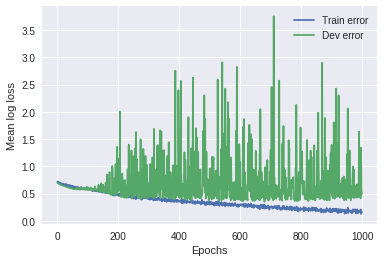

In [31]:
train_curve, = plt.plot(hist.history['loss'], label = 'Train error')
test_curve,  = plt.plot(hist.history['val_loss'], label = 'Dev error')
plt.legend(handles=[train_curve,test_curve])
plt.xlabel('Epochs')
plt.ylabel('Mean log loss')
plt.show()

The results speak for themselves. The accuracy increased dramatically to about 90% (89% - 92% depending on the validation metric you are looking at) and the dev error decreased to about 0.35, a 40% error decrease. 

The learning curves oscillate heavily due to two facts combined. One is the random nature of data augmentation. Especulatively speaking, every epoch presents a "different" dataset to backprop, and the gradient directions change with respect to each augmented dataset. The other factor is the higher learning rate used. We have been using learning rates in the scale of $10^{-6}$ to $10^{-5}$ for the sake of a smoother learning. However, we had to increase it to $10^{-4}$ for the sake of running time. Therefore, this learning rate amplified the erratic nature of the randomly augmented gradients. 

If you draw a line at the bottom of the dev error curve, it will approximate convex curve. This is tipical to a learning curve, meaning, the model is fitting untill the minimum in the dev error, after that, the model starts to overfit and the dev error starts to increase. This is a good result showing that 1000 epochs were enough to fit the dataset, overfitting around 600-800 epochs. Indeed, the minimum dev error occured on epoch 608, while the maximum dev accuracy occured on epoch 824. Tha

All factors - convolution, pooling, dataset augmentation, 8 layers deep model and batch normalization - contributed to this increase in 20% in absolute difference accuracy. This only demonstrates how and why this was the first widely acclaimed deep learning architecture.

We end this notebook here for the sake of your patience, but we will continue to explore the latest deep learning methodologies in the next notebook.

We hope that, by the end of the next notebook we can already have an idea of where to go in terms of architecture. So later, we will address our second biggest issue, low resolution, using an even larger dataset in terms of samples and of pixel density. Stay tuned!